# Clasificador de Imágenes de Gatos (Siamese vs Sphynx) usando OpenCV y ML

## Introducción

El objetivo de esta práctica es desarrollar un clasificador de imágenes que pueda distinguir entre dos razas específicas de gatos (Siamese y Sphynx) utilizando el conjunto de datos Oxford-IIIT Pet Dataset. Utilizaremos OpenCV para preprocesar las imágenes y extraer características relevantes, y luego entrenaremos un modelo de aprendizaje automático con dichas características. El objetivo principal no es lograr el modelo más preciso, sino comprender y mejorar el proceso de extracción y refinamiento de información a partir de los datos de las imágenes.

## Pasos a seguir durante el trabajo

### 1. Importación de Librerías

### 2. Carga y visualizacion de imagnes

### 3. Defincion y creacion de las funciones de preproceaamineto usadas

### 4. Defincion y creacion de una clase Pipeline que junte los tres procesos: Extraccion, transformacion y entrenamiento (y validacion) del modelo

### 6. Ejecución del Proceso Completo: Defincion de intentos segun ciertos objetivos de preporcesamiento de las imagenes.

Se intenta, segun cierta estrategia preprocesar las iamgenes con ciertos metodos que mejoren las prediciiones posterioreres del modelo.

### 7. Predicion final

Desarrollamos una función para mostrar algunas imágenes con sus etiquetas verdaderas y predicciones para verificar visualmente el rendimiento del modelo.


### Problemas Encontrados y Soluciones propuestas

1. **...**:
   - **Solución**: ...

### Mejoras Futuras

1. Probar otros modelos de aprendizaje automático como Random Forest y Redes Neuronales.
2. Implementar más técnicas de aumento de datos y evaluar su impacto en el rendimiento del modelo.

# Clasificador de Imágenes de Gatos (Siamese vs Sphynx) usando OpenCV y ML

In [2]:
!pip install opencv-python umap-learn scikit-learn

In [77]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.image as mpimg
import random
from sklearn.manifold import TSNE
import umap
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix


In [78]:
# En caso de usar colab
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

# Carga de datos, creacion de test y train [carpetas] y division de razas

In [79]:
images_path = "images"
annotations_path = "annotations"

trainval = open(os.path.join(annotations_path, "trainval.txt")).readlines()
test = open(os.path.join(annotations_path, "test.txt")).readlines()

# Crear directorios para las razas de gato Siamese y Sphynx
os.makedirs(os.path.join(images_path, "train", "Siamese"), exist_ok=True)
os.makedirs(os.path.join(images_path, "train", "Sphynx"), exist_ok=True)
os.makedirs(os.path.join(images_path, "test", "Siamese"), exist_ok=True)
os.makedirs(os.path.join(images_path, "test", "Sphynx"), exist_ok=True)

def classify_image(line, subset):
    elements = line.split(" ")
    breed_info = elements[0].split("_")
    breed = breed_info[0]

    if breed in ["Siamese", "Sphynx"]:
        oldpath = os.path.join(images_path, f"{elements[0]}.jpg")
        newpath = os.path.join(images_path, subset, breed, f"{elements[0]}.jpg")
        if os.path.isfile(oldpath):
            os.rename(oldpath, newpath)

for line in trainval:
    classify_image(line, "train")

for line in test:
    classify_image(line, "test")


# Visualización previa

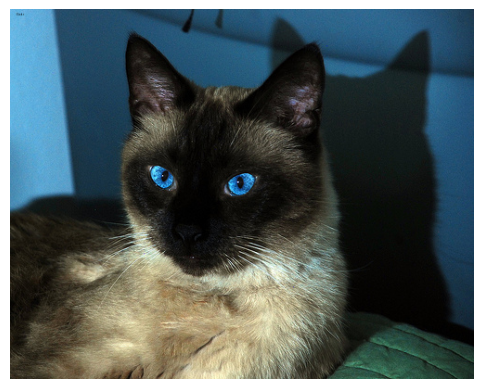

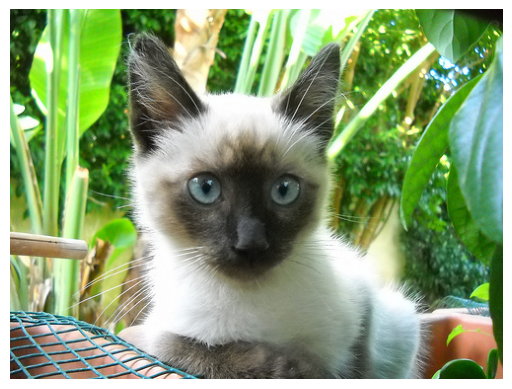

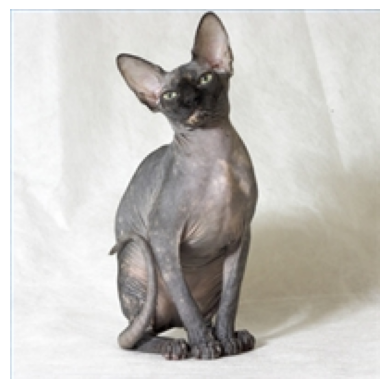

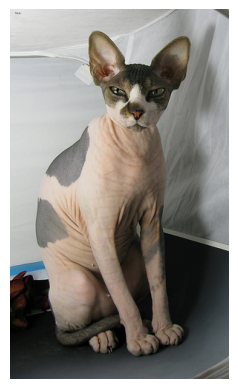

In [80]:
# Función para cargar imágenes de un directorio dado
def load_images_from_directory(directory, num_images=2):
    image_files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    selected_files = random.sample(image_files, min(len(image_files), num_images))
    images = [mpimg.imread(f) for f in selected_files]
    return images

# Cargar algunas imágenes de los directorios de train y test
train_siamese_images = load_images_from_directory(os.path.join(images_path, "train", "Siamese"))
test_sphynx_images = load_images_from_directory(os.path.join(images_path, "test", "Sphynx"))

# Visualizar las imágenes
def show_images(images):
    for img in images:
        plt.imshow(img / 255.0)
        plt.axis('off')
        plt.show()

# Mostrar algunas imágenes de train y test
show_images(train_siamese_images)
show_images(test_sphynx_images)

# Funciones de preprocesamiento necesarias

In [95]:
def apply_fourier_transform(img):
    """
    Aplica la transformada de Fourier a la imagen.

    Args:
        img (np.array): Imagen de entrada.

    Returns:
        np.array: Imagen con la transformada de Fourier aplicada.
    """
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(img_gray)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift))
    magnitude_spectrum = np.uint8(magnitude_spectrum)  # Convertir a uint8
    return cv2.merge([magnitude_spectrum] * 3)  # Convertir a 3 canales para mantener el formato

def apply_mask(img):
    """
    Aplica una máscara para eliminar el fondo y resaltar solo al gato.

    Args:
        img (np.array): Imagen de entrada.

    Returns:
        np.array: Imagen con el fondo eliminado.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    return masked_img


def convert_to_hsv(img):
    """
    Convierte la imagen al espacio de color HSV y extrae el canal de saturación.

    Args:
        img (np.array): Imagen de entrada.

    Returns:
        np.array: Imagen con el canal de saturación resaltado.
    """
    if len(img.shape) == 2:
        # Si la imagen es en escala de grises, convertirla a BGR
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    elif img.shape[2] == 1:
        # Si la imagen tiene un solo canal, convertirla a BGR
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    return s



def adjust_brightness_contrast(image, alpha=1.0, beta=0):
    """
    Ajusta el brillo y el contraste de la imagen.

    Args:
        image (np.array): Imagen de entrada.
        alpha (float): Factor de contraste.
        beta (int): Valor de brillo.

    Returns:
        np.array: Imagen con brillo y contraste ajustados.
    """
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

def augment_image(image, img_size):
    """
    Aplica aumentos de datos a la imagen.

    Args:
        image (np.array): Imagen a aumentar.
        img_size (tuple): Tamaño al que se redimensionarán las imágenes.

    Returns:
        list: Lista de imágenes aumentadas.
    """
    augmented_images = []
    angles = [-30, -15, 15, 30]
    translations = [(-10, -10), (-10, 10), (10, -10), (10, 10)]
    scales = [0.8, 1.2]

    for angle in angles:
        aug_img = rotate_image(image, angle)
        aug_img = cv2.resize(aug_img, img_size)
        augmented_images.append(aug_img)

    for (x, y) in translations:
        aug_img = translate_image(image, x, y)
        aug_img = cv2.resize(aug_img, img_size)
        augmented_images.append(aug_img)

    for scale in scales:
        aug_img = scale_image(image, scale)
        aug_img = cv2.resize(aug_img, img_size)
        augmented_images.append(aug_img)

    aug_img = adjust_brightness_contrast(image, alpha=1.5, beta=50)
    aug_img = cv2.resize(aug_img, img_size)
    augmented_images.append(aug_img)

    aug_img = adjust_brightness_contrast(image, alpha=0.5, beta=-50)
    aug_img = cv2.resize(aug_img, img_size)
    augmented_images.append(aug_img)

    return augmented_images

def rotate_image(image, angle):
    """
    Rota la imagen un ángulo especificado.

    Args:
        image (np.array): Imagen a rotar.
        angle (float): Ángulo de rotación en grados.

    Returns:
        np.array: Imagen rotada.
    """
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    return cv2.warpAffine(image, M, (w, h))

def translate_image(image, x, y):
    """
    Translacion de la imagen en las direcciones x e y especificadas.

    Args:
        image (np.array): Imagen a traducir.
        x (int): Desplazamiento en el eje x.
        y (int): Desplazamiento en el eje y.

    Returns:
        np.array: Imagen traducida.
    """
    M = np.float32([[1, 0, x], [0, 1, y]])
    h, w = image.shape[:2]
    return cv2.warpAffine(image, M, (w, h))

def scale_image(image, scale):
    """
    Escala la imagen por un factor especificado.

    Args:
        image (np.array): Imagen a escalar.
        scale (float): Factor de escala.

    Returns:
        np.array: Imagen escalada.
    """
    h, w = image.shape[:2]
    return cv2.resize(image, (int(w*scale), int(h*scale)))

def extract_sift_features(images):
    """
    Extrae características SIFT de un conjunto de imágenes.

    Args:
        images (np.array): Conjunto de imágenes.

    Returns:
        np.array: Características extraídas.
    """
    sift = cv2.SIFT_create()
    features = []
    max_features = 0

    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, des = sift.detectAndCompute(gray, None)
        if des is not None:
            features.append(des.flatten())
            if des.shape[0] > max_features:
                max_features = des.shape[0]
        else:
            features.append(np.zeros(128))

    # Padding the features to have the same size
    for i in range(len(features)):
        if len(features[i]) < max_features * 128:
            features[i] = np.pad(features[i], (0, max_features * 128 - len(features[i])), mode='constant')

    return np.array(features)

def extract_surf_features(images):
    """
    Extrae características SURF de un conjunto de imágenes.

    Args:
        images (np.array): Conjunto de imágenes.

    Returns:
        np.array: Características extraídas.
    """
    surf = cv2.xfeatures2d.SURF_create()
    features = []
    max_features = 0

    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, des = surf.detectAndCompute(gray, None)
        if des is not None:
            features.append(des.flatten())
            if des.shape[0] > max_features:
                max_features = des.shape[0]
        else:
            features.append(np.zeros(64))

    # Padding the features to have the same size
    for i in range(len(features)):
        if len(features[i]) < max_features * 64:
            features[i] = np.pad(features[i], (0, max_features * 64 - len(features[i])), mode='constant')

    return np.array(features)

def extract_orb_features(images):
    """
    Extrae características ORB de un conjunto de imágenes.

    Args:
        images (np.array): Conjunto de imágenes.

    Returns:
        np.array: Características extraídas.
    """
    orb = cv2.ORB_create()
    features = []
    max_features = 0

    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, des = orb.detectAndCompute(gray, None)
        if des is not None:
            features.append(des.flatten())
            if des.shape[0] > max_features:
                max_features = des.shape[0]
        else:
            features.append(np.zeros(32))

    # Padding the features to have the same size
    for i in range(len(features)):
        if len(features[i]) < max_features * 32:
            features[i] = np.pad(features[i], (0, max_features * 32 - len(features[i])), mode='constant')

    return np.array(features)

def apply_mask(img):
    """
    Aplica una máscara para eliminar el fondo y resaltar solo al gato.

    Args:
        img (np.array): Imagen de entrada.

    Returns:
        np.array: Imagen con el fondo eliminado.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    return masked_img

def highlight_gray_tones(img):
    """
    Resalta los tonos grisáceos de la imagen para distinguir los gatos esfinge de los siameses.

    Args:
        img (np.array): Imagen de entrada.

    Returns:
        np.array: Imagen con los tonos grisáceos resaltados.
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_gray = np.array([0, 0, 40])
    upper_gray = np.array([180, 50, 255])
    mask = cv2.inRange(hsv, lower_gray, upper_gray)
    result = cv2.bitwise_and(img, img, mask=mask)
    return result

# clase Pipeline de preprocesamiento

In [96]:
class Pipeline:
    def __init__(self, path_siamese, path_sphynx, img_size=(128, 128)):
        self.path_siamese = path_siamese
        self.path_sphynx = path_sphynx
        self.img_size = img_size
        self.images = []
        self.labels = []
        self.preprocess_functions = []
        self.breeds = ['Siamese', 'Sphynx']
        self.model = None

    def add_preprocess_function(self, func):
        """
        Añade una función de preprocesamiento a la lista de funciones.

        Args:
            func (function): Función de preprocesamiento.
        """
        self.preprocess_functions.append(func)

    def load_images(self):
        """
        Carga y preprocesa las imágenes de las razas especificadas.

        Returns:
            np.array: Imágenes cargadas y preprocesadas.
            np.array: Etiquetas correspondientes a las imágenes.
        """
        for breed, path in [('Siamese', self.path_siamese), ('Sphynx', self.path_sphynx)]:
            for img_name in os.listdir(path):
                if img_name.endswith('.jpg'):
                    img_path = os.path.join(path, img_name)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, self.img_size)
                        if len(img.shape) == 2 or img.shape[2] == 1:
                            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
                        for func in self.preprocess_functions:
                            img = func(img)
                        self.images.append(img)
                        self.labels.append(breed)
        self.images = np.array(self.images)
        self.labels = np.array(self.labels)

    def preprocess_image(self, img):
        """
        Aplica las funciones de preprocesamiento a la imagen.

        Args:
            img (np.array): Imagen a preprocesar.

        Returns:
            np.array: Imagen preprocesada.
        """
        for func in self.preprocess_functions:
            img = func(img)
        return img

    def augment_images(self):
        """
        Aplica aumentos de datos a las imágenes cargadas.

        Returns:
            np.array: Imágenes aumentadas.
            np.array: Etiquetas correspondientes a las imágenes aumentadas.
        """
        augmented_images = []
        augmented_labels = []
        for img, label in zip(self.images, self.labels):
            augmented_images.append(img)
            augmented_labels.append(label)
            augmented_set = augment_image(img, self.img_size)
            for aug_img in augmented_set:
                augmented_images.append(aug_img)
                augmented_labels.append(label)
        self.images = np.array(augmented_images)
        self.labels = np.array(augmented_labels)

    def extract_features(self, images, method='orb'):
        """
        Extrae características de las imágenes usando el método especificado.

        Args:
            images (np.array): Imágenes de las que extraer características.
            method (str): Método de extracción de características ('sift', 'surf', 'orb').

        Returns:
            np.array: Características extraídas.
        """
        if method == 'sift':
            return extract_sift_features(images)
        elif method == 'surf':
            return extract_surf_features(images)
        elif method == 'orb':
            return extract_orb_features(images)
        else:
            raise ValueError("Método de extracción de características no soportado: {}".format(method))

    def apply_tsne(self, features):
        """
        Aplica T-SNE para reducir la dimensionalidad de las características.

        Args:
            features (np.array): Características extraídas.

        Returns:
            np.array: Embedding de T-SNE.
        """
        tsne = TSNE(n_components=2, random_state=42)
        embedding = tsne.fit_transform(features)
        return embedding

    def plot_embedding(self, embedding, title='Embedding of Cat Breeds'):
        """
        Grafica el embedding en 2D con las etiquetas de las imágenes.

        Args:
            embedding (np.array): Embedding de T-SNE o UMAP.
        """
        plt.figure(figsize=(12, 8))
        for i, label in enumerate(np.unique(self.labels)):
            plt.scatter(
                embedding[self.labels == label, 0],
                embedding[self.labels == label, 1],
                label=label
            )
        plt.legend()
        plt.title(title)
        plt.show()

    def train_and_evaluate_model(self, features):
        """
        Entrena y evalúa un modelo de clasificación usando las características extraídas.

        Args:
            features (np.array): Características extraídas.
        """
        X_train, X_test, y_train, y_test = train_test_split(features, self.labels, test_size=0.3, random_state=42)
        model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        self.model = model  # Guarda el modelo entrenado para predicciones futuras

        # Calcular métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        auc = roc_auc_score(y_test, y_pred_proba)

        # Crear un DataFrame con las métricas
        metrics_df = pd.DataFrame({
            'Accuracy': [accuracy],
            'Precision': [precision],
            'Recall': [recall],
            'F1 Score': [f1],
            'AUC': [auc]
        })

        # Mostrar el DataFrame
        print(metrics_df)

        # Imprimir el reporte de clasificación y la matriz de confusión
        print(classification_report(y_test, y_pred))
        print(confusion_matrix(y_test, y_pred))





# Preprocesamiento, transformaciones y entrenamiento
A continuación se exponen y detallan los intentos por mejorar las predicciones del modelo haciendo uso de varias tranformaciones

## Intento 1

```python
pipeline.add_preprocess_function(adjust_brightness_contrast)
pipeline.add_preprocess_function(apply_mask)
pipeline.add_preprocess_function(apply_fourier_transform)

# Cargar y preprocesar las imágenes
pipeline.load_images()

# Aumentar los datos
pipeline.augment_images()

# Extraer características
features = pipeline.extract_features(pipeline.images, method='orb')
```

#### Estrategia
1. **adjust_brightness_contrast**:
   - **Objetivo**: Mejorar el contraste y la iluminación de las imágenes.
   - **Descripción**: Ajusta el brillo y el contraste de la imagen usando factores específicos.
   
2. **apply_mask**:
   - **Objetivo**: Eliminar el fondo de la imagen y resaltar solo al gato.
   - **Descripción**: Convierte la imagen a escala de grises, aplica una umbralización binaria y encuentra contornos para crear una máscara, que luego se aplica a la imagen original.

3. **apply_fourier_transform**:
   - **Objetivo**: Obtener características del dominio de la frecuencia.
   - **Descripción**: Convierte la imagen a escala de grises y aplica la transformada de Fourier para obtener el espectro de magnitud. Este espectro se convierte a uint8 y se duplica a tres canales.

4. **Método de extracción de características `orb`**:
   - **Objetivo**: Extraer características robustas de las imágenes.
   - **Descripción**: ORB (Oriented FAST and Rotated BRIEF) es un método de detección y descripción de características que es rápido y eficiente, adecuado para imágenes en las que se desea identificar patrones específicos.

In [84]:
path_siamese = 'images/train/Siamese'
path_sphynx = 'images/train/Sphynx'

pipeline = Pipeline(path_siamese, path_sphynx)

pipeline.add_preprocess_function(adjust_brightness_contrast)
pipeline.add_preprocess_function(apply_mask)
pipeline.add_preprocess_function(apply_fourier_transform)

pipeline.load_images()

pipeline.augment_images()

features = pipeline.extract_features(pipeline.images, method='orb')

pipeline.train_and_evaluate_model(features)


   Accuracy  Precision    Recall  F1 Score  AUC
0  0.519949   0.519585  0.519949  0.515384  0.5
              precision    recall  f1-score   support

     Siamese       0.52      0.42      0.46       384
      Sphynx       0.52      0.62      0.56       393

    accuracy                           0.52       777
   macro avg       0.52      0.52      0.51       777
weighted avg       0.52      0.52      0.52       777

[[162 222]
 [151 242]]


## Intento 2

```python
# Agregar funciones de preprocesamiento
pipeline.add_preprocess_function(highlight_gray_tones)
pipeline.add_preprocess_function(apply_mask)
pipeline.add_preprocess_function(apply_fourier_transform)

# Cargar y preprocesar las imágenes
pipeline.load_images()

# Aumentar los datos
pipeline.augment_images()

# Extraer características
features = extract_features(pipeline.images, method='sift')

# Entrenar y evaluar el modelo
pipeline.train_and_evaluate_model(features)
```

#### Estrategia
1. **Localizar y aislar la cara mediante transformaciones**.
2. **Transformación de color y transformada de Fourier**.

- **highlight_gray_tones**:
   - **Objetivo**: Resaltar los tonos grisáceos de la imagen para distinguir los gatos esfinge de los siameses.
   - **Descripción**: Esta función convierte la imagen al espacio de color HSV y aplica un filtro para resaltar los tonos grisáceos. La máscara resultante se aplica a la imagen original.

- **apply_mask**:
   - **Objetivo**: Eliminar el fondo de la imagen y resaltar solo al gato.
   - **Descripción**: Convierte la imagen a escala de grises, aplica una umbralización binaria y encuentra contornos para crear una máscara, que luego se aplica a la imagen original.

- **apply_fourier_transform**:
   - **Objetivo**: Obtener características del dominio de la frecuencia.
   - **Descripción**: Convierte la imagen a escala de grises y aplica la transformada de Fourier para obtener el espectro de magnitud. Este espectro se convierte a uint8 y se duplica a tres canales.

- **Método de extracción de características `sift`**:
   - **Objetivo**: Extraer características distintivas de las imágenes para identificar y describir puntos clave en las imágenes.
   - **Descripción**: SIFT (Scale-Invariant Feature Transform) es un algoritmo de visión por computadora que detecta y describe características locales en las imágenes. SIFT transforma una imagen en una gran colección de características locales invariantes con respecto a la escala y la rotación. Estas características son útiles para la detección de objetos, el emparejamiento de imágenes y el reconocimiento de patrones. SIFT identifica puntos clave en la imagen y calcula un descriptor de estos puntos clave que es robusto a los cambios de escala, rotación y, en cierta medida, a la iluminación.


In [89]:
path_siamese = 'images/train/Siamese'
path_sphynx = 'images/train/Sphynx'

pipeline = Pipeline(path_siamese, path_sphynx) 

# Agregar funciones de preprocesamiento
pipeline.add_preprocess_function(highlight_gray_tones)
pipeline.add_preprocess_function(apply_mask)
pipeline.add_preprocess_function(apply_fourier_transform)

# Cargar y preprocesar las imágenes
pipeline.load_images()

# Aumentar los datos
pipeline.augment_images()

# Extraer características
features = pipeline.extract_features(pipeline.images, method='sift')

# Entrenar y evaluar el modelo
pipeline.train_and_evaluate_model(features)


C:\Users\Jorge\AppData\Local\Temp\ipykernel_8696\505242211.py:14: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20 * np.log(np.abs(fshift))
C:\Users\Jorge\AppData\Local\Temp\ipykernel_8696\505242211.py:15: RuntimeWarning: invalid value encountered in cast
  magnitude_spectrum = np.uint8(magnitude_spectrum)  # Convertir a uint8


   Accuracy  Precision    Recall  F1 Score       AUC
0  0.555985   0.561857  0.555985  0.548456  0.571426
              precision    recall  f1-score   support

     Siamese       0.54      0.69      0.60       384
      Sphynx       0.58      0.43      0.49       393

    accuracy                           0.56       777
   macro avg       0.56      0.56      0.55       777
weighted avg       0.56      0.56      0.55       777

[[264 120]
 [225 168]]


## Intento 3

```python
# Agregar funciones de preprocesamiento
pipeline.add_preprocess_function(highlight_gray_tones)
pipeline.add_preprocess_function(apply_mask)

# Cargar y preprocesar las imágenes
pipeline.load_images()

# Extraer características
features = pipeline.extract_features(pipeline.images, method='orb')

# Entrenar y evaluar el modelo
pipeline.train_and_evaluate_model(features)

```

#### Estrategia
1. **Localizar y aislar la cara mediante transformaciones**.
2. **Transformación de color y transformada de Fourier**.

- **highlight_gray_tones**:
   - **Objetivo**: Resaltar los tonos grisáceos para distinguir los gatos esfinge de los siameses.
   - **Descripción**: Convierte la imagen al espacio de color HSV y aplica un filtro para resaltar los tonos grisáceos. Aplica la máscara resultante a la imagen original.

- **apply_mask**:
   - **Objetivo**: Eliminar el fondo de la imagen y resaltar solo al gato.
   - **Descripción**: Convierte la imagen a escala de grises, aplica una umbralización binaria y encuentra contornos para crear una máscara, que luego se aplica a la imagen original.


ierte la imagen a escala de grises y aplica la transformada de Fourier para obtener el espectro de magnitud. Este espectro se convierte a uint8 y se duplica a tres canales.

- **Método de extracción de características `orb`**:
   - **Objetivo**: Extraer características robustas de las imágenes.
   - **Descripción**: ORB (Oriented FAST and Rotated BRIEF) es un método de detección y descripción de características que es rápido y eficiente, adecuado para imágenes en las que se desea identificar patrones específicos.


In [103]:
path_siamese = 'images/train/Siamese'
path_sphynx = 'images/train/Sphynx'

pipeline = Pipeline(path_siamese, path_sphynx) 

# Agregar funciones de preprocesamiento
pipeline.add_preprocess_function(highlight_gray_tones)

# Cargar y preprocesar las imágenes
pipeline.load_images()

# Extraer características
# features = pipeline.extract_features(pipeline.images, method='orb')
features = pipeline.extract_features(pipeline.images, method='sift')

# Entrenar y evaluar el modelo
pipeline.train_and_evaluate_model(features)

   Accuracy  Precision    Recall  F1 Score       AUC
0  0.516667   0.523485  0.516667  0.508092  0.555617
              precision    recall  f1-score   support

     Siamese       0.50      0.66      0.57        29
      Sphynx       0.55      0.39      0.45        31

    accuracy                           0.52        60
   macro avg       0.52      0.52      0.51        60
weighted avg       0.52      0.52      0.51        60

[[19 10]
 [19 12]]


**Accuracy**: 0.533333

```python
# Agregar funciones de preprocesamiento
pipeline.add_preprocess_function(apply_mask)
pipeline.add_preprocess_function(highlight_gray_tones)
pipeline.add_preprocess_function(apply_fourier_transform)

# Cargar y preprocesar las imágenes
pipeline.load_images()

# Aumentar los datos
pipeline.augment_images()

# Extraer características
features = pipeline.extract_features(pipeline.images, method='orb')

# Entrenar y evaluar el modelo
pipeline.train_and_evaluate_model(features)
```

#### Estrategia
1. **Localizar y aislar la cara mediante transformaciones**.
2. **Transformación de color y transformada de Fourier**.

- **apply_mask**:
   - **Objetivo**: Eliminar el fondo de la imagen, dejando solo al gato visible.
   - **Descripción**: Convierte la imagen a escala de grises, aplica umbralización binaria y encuentra contornos para crear una máscara. Luego, aplica la máscara a la imagen original para eliminar el fondo.

- **highlight_gray_tones**:
   - **Objetivo**: Resaltar los tonos grisáceos para distinguir los gatos esfinge de los siameses.
   - **Descripción**: Convierte la imagen al espacio de color HSV y aplica un filtro para resaltar los tonos grisáceos. Aplica la máscara resultante a la imagen original.

- **Método de extracción de características `orb`**:
   - **Objetivo**: Extraer características robustas de las imágenes.
   - **Descripción**: ORB (Oriented FAST and Rotated BRIEF) es un método de detección y descripción de características que es rápido y eficiente, adecuado para imágenes en las que se desea identificar patrones específicos.

In [104]:
path_siamese = 'images/train/Siamese'
path_sphynx = 'images/train/Sphynx'

pipeline = Pipeline(path_siamese, path_sphynx) 

# Agregar funciones de preprocesamiento
pipeline.add_preprocess_function(apply_mask)
pipeline.add_preprocess_function(highlight_gray_tones)

# Cargar y preprocesar las imágenes
pipeline.load_images()

# Aumentar los datos
pipeline.augment_images()

# Extraer características
features = pipeline.extract_features(pipeline.images, method='orb')

# Entrenar y evaluar el modelo
pipeline.train_and_evaluate_model(features)

   Accuracy  Precision    Recall  F1 Score       AUC
0  0.625483   0.626216  0.625483  0.624423  0.686029
              precision    recall  f1-score   support

     Siamese       0.63      0.57      0.60       384
      Sphynx       0.62      0.68      0.65       393

    accuracy                           0.63       777
   macro avg       0.63      0.62      0.62       777
weighted avg       0.63      0.63      0.62       777

[[220 164]
 [127 266]]


# Predicciones

In [65]:
test_images = [
    './images/test/Siamese/Siamese_5.jpg',
    './images/test/Sphynx/Sphynx_2.jpg',
]
test_labels = [
    'Siamese',
    'Sphynx'
]
display_predictions(test_images, test_labels, pipeline.model, pipeline.preprocess_functions, pipeline.breeds)

TypeError: display_predictions() takes from 3 to 4 positional arguments but 5 were given

# Conclusiones según resultados